<a href="https://colab.research.google.com/github/chrdrn/digital-behavioral-data-binder/blob/main/session_08-showcase_text_as_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<IMG SRC="https://raw.githubusercontent.com/chrdrn/digital-behavioral-data/main/img/dbd_hex.png" WIDTH=15% HEIGHT=15% ALIGN="left" HSPACE="20" VSPACE="20" /> 
<h1>Disclaimer </h1>
<p>For reasons of research ethics and out of respect for privacy the data collected and processed in the course will be managed in a private OSF repository. Students will only have access to this OSF repository for a limited period of time. </p>
<p>Although the collection of data is (at least) partially documented in the showcases, detailed instructions can be found in the slides of course for the respective session. </p>
<p> Link: <a href="https://chrdrn.github.io/digital-behavioral-data/">https://chrdrn.github.io/digital-behavioral-data/</a>
</p>

<BR CLEAR=”left” />

---
### <img src="https://icons.getbootstrap.com/assets/icons/info-circle-fill.svg" width="15" height="15"> Technical note

While the chunk outputs were saved, the data basis was not. For an error-free execution of this notebook, the data must be collected and reloaded. All chunks for which the path to the data must be re-entered are marked with the following symobl: <img src="https://icons.getbootstrap.com/assets/icons/database-fill-down.svg" width="15" height="15">

---

## Preparation

*   Due to the low processing power of Google Colab, scraping the Amazon reviews and calculating the topic model could take a very long time. 
*   Therefore, it is highly recommended to load the dataset that contains all the data(sets) created in this Colab and only run the chunks that contain analysis and/or render graphs (marked with <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15">) 




### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Define global options



In [ ]:
# Define options for output
set.seed(42)
options(
  scipen = 999, # turn of scientifc notation
  repr.plot.width=12,
  repr.plot.height=8)

### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Install & load packages

Install addtional necessary packages

**⚠ It might take a few minutes to install all packages and dependencies**

In [ ]:
install.packages("pacman")

p_load(
  pacman,
  tidyverse
)

### <img src="https://icons.getbootstrap.com/assets/icons/database-fill-down.svg" width="15" height="15"> Recommended: Import (complete) data local



In [ ]:
amazon <- readRDS(ADD_DATA_PATH_HERE)

# Check data structure and sublists
amazon |> summary()

     Length Class  Mode
raw  5      -none- list
data 6      -none- list
temp 4      -none- list
txt  4      -none- list
tpm  5      -none- list
stm  3      -none- list

## Scrape Amazon reviews

*   based on [stackoverflow post](https://stackoverflow.com/a/70993803).

### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Install & load packages


In [ ]:
pacman::p_load( magrittr)

### Create custom function

*   `scrape_amazon` function with two arguments
  *   `page_num`: The number of the review page that is to be scraped
  *   `review_url`: URL of review page for the product


In [ ]:
scrape_amazon <- function(page_num, review_url) {
  url_reviews <- paste0(review_url, "&pageNumber=", page_num, "&sortBy=recent")
  doc <- read_html(url_reviews)
  map_dfr(doc %>% html_elements("[id^='customer_review']"), ~ data.frame(
    review_title = .x %>% html_element(".review-title") %>% html_text2(),
    review_text = .x %>% html_element(".review-text-content") %>% html_text2(),
    review_star = .x %>% html_element(".review-rating") %>% html_text2(),
    date = .x %>% html_element(".review-date") %>% html_text2() %>% gsub(".*vom ", "", .),
    author = .x %>% html_element(".a-profile-name") %>% html_text2(),
    page = page_num
  )) %>%
    as_tibble %>%
    return()
}

### Define product urls

-   `p01` (*Lineavi*): 1.679 Gesamtbewertungen, 782 mit Rezensionen --\> 79 pages
-   `p02` (*DietySlim*): 1.652 Gesamtbewertungen, 268 mit Rezensionen --\> 28 pages
-   `p03` (*Keto Burn*): 3.341 Gesamtbewertungen, 540 mit Rezensionen --\> 55 pages
-   `p04` (*Yokebe*): 1.586 Gesamtbewertungen, 156 mit Rezensionen --\> 16 pages
-   `p05` (*Vihado*): 1.335 Gesamtbewertungen, 396 mit Rezensionen --\> 40 pages


In [ ]:
url <- list(
  p01 = "https://www.amazon.de/LINEAVI-Eiwei%C3%9F-Shake-Kombination-Molkeneiwei%C3%9F-laktosefrei/product-reviews/B018IB02AU/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews",
  p02 = "https://www.amazon.de/Detoxkuren%E2%80%A2-Entw%C3%A4sserung-Entschlackung-Stoffwechsel-entschlacken/product-reviews/B072QW5ZN1/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews",
  p03 = "https://www.amazon.de/Saint-Nutrition%C2%AE-KETO-BURN-Appetitz%C3%BCgler/product-reviews/B08B67V8G5/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews",
  p04 = "https://www.amazon.de/Yokebe-vegetarisch-Mahlzeitersatz-Gewichtsabnahme-hochwertigen/product-reviews/B08GYZ8LRB/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews",
  p05 = "https://www.amazon.de/Vihado-Liquid-chlorophyll-drops-alfalfa/product-reviews/B093XNC8QH/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews"
)

###  Scrape reviews for products
- Create a list to store the output (`amazon`) 
- Scrape all review (pages) for all products (`p01`:`p05`)

In [ ]:
# Create list for output
amazon <- list()

# Scrape reviews o
## p01 
for (i in 1:79) {
  df <- scrape_amazon(page_num = i, review_url = url$p01)
  amazon$raw$p01[[i]] <- df
}

## p02
for (i in 1:28) {
  df <- scrape_amazon(page_num = i, review_url = url$p02)
  amazon$raw$p02[[i]] <- df
}

## p03
for (i in 1:55) {
  df <- scrape_amazon(page_num = i, review_url = url$p03)
  amazon$raw$p03[[i]] <- df
}

## p04
for (i in 1:16) {
  df <- scrape_amazon(page_num = i, review_url = url$p04)
  amazon$raw$p04[[i]] <- df
}

## p05
for (i in 1:40) {
  df <- scrape_amazon(page_num = i, review_url = url$p05)
  amazon$raw$p05[[i]] <- df
}

### Bind rows

In [ ]:
# Create vector with variable names of products
product <- names(url)

# bind rows for each product
for (i in product) {
  amazon$data$raw[[i]] <- amazon$raw[[i]] %>% 
    bind_rows() %>% 
    rownames_to_column("id") %>% 
    mutate(across(id, as.numeric))
}

# bind rows of all products
amazon$data$full <- amazon$data$raw %>% 
  bind_rows(.id = "src")

## Data processing

Several steps are necessary to use the data in further analysis: 
- Create unique identifiers (`doc_id` & `id`)
- Create and edit `date` variables
- Check for language of the review


### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Install & load packages


In [ ]:
pacman::p_load(
  fastText, stringr, lubridate,
  sjmisc
)

### Data wrangling

In [ ]:
amazon$data$clean <- amazon$data$full %>% 
  # create doc_id
  rownames_to_column(., var = "doc_id") %>% 
  mutate(
    # create unique ids (src_id, doc_id)
    src_id = id, 
    id = paste(src, sprintf("%03d", id), sep = "_"),
    # convert to factor
    across(c(id, src), as.factor),
    across(doc_id, as.numeric),
        # review body
    review_body = paste(review_title, review_text),
    body_trimmed = str_replace_all(review_body, "[\r\n]" , ""), # delete line breaks
    lang_detect = fastText::language_identification(
      body_trimmed,
      system.file("language_identification/lid.176.ftz", package = "fastText")),
    lang = lang_detect$iso_lang_1,
    lang_prob = lang_detect$prob_1,
    # edit date variable
    date_raw = date,
    date_base = str_extract(date_raw, "\\d{1,2}(.*)\\d{1,4}"),
    ## Change date format to DD.MM.YYYY
    across(date_base, str_replace, " Januar ", "01."),
    across(date_base, str_replace, " Februar ", "02."),
    across(date_base, str_replace, " März ", "03."),
    across(date_base, str_replace, " April ", "04."),
    across(date_base, str_replace, " Mai ", "05."),
    across(date_base, str_replace, " Juni ", "06."),
    across(date_base, str_replace, " Juli ", "07."),
    across(date_base, str_replace, " August ", "08."),
    across(date_base, str_replace, " September ", "09."),
    across(date_base, str_replace, " Oktober ", "10."),
    across(date_base, str_replace, " November ", "11."),
    across(date_base, str_replace, " Dezember ", "12."),
    ## Convert to date
    date = as.Date(date_base, format = "%d.%m.%Y"),
    ## create date variables
    year = as.factor(year(date)),
    month = as.factor(month(date)),
    day = as.factor(day(date)),
    rating  = as.numeric(str_extract(review_star, "\\d{1}(?=,)")) 
    ) %>% 
  # relcoate variables
  relocate(starts_with("src"), .after = id) %>%
  relocate(starts_with("date"), .after = src_id) %>%
  relocate(year,month,day, .before = review_title) %>%
  relocate(starts_with("lang"), .after = page) %>% 
  relocate(starts_with("review"), .after = lang_prob) %>%
  relocate(review_star, .after = body_trimmed)

### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Check language identification


In [ ]:
# Languages
amazon$data$clean %>% 
  frq(lang)

In [ ]:
# Identification probability
amazon$data$clean %>% 
  group_by(lang) %>% 
  summarise(
    n = n(), 
    prob = mean(lang_prob))

### Select only german reviews


In [ ]:
amazon$data$de <- amazon$data$clean %>% 
  filter(lang == "de")

## Exploratory data analysis

### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Load packages

In [ ]:
pacman::p_load(
  ggsci, ggpubr
)

### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Number of reviews by product


In [ ]:
amazon$data$de %>% 
  frq(src)

### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Reviews by year

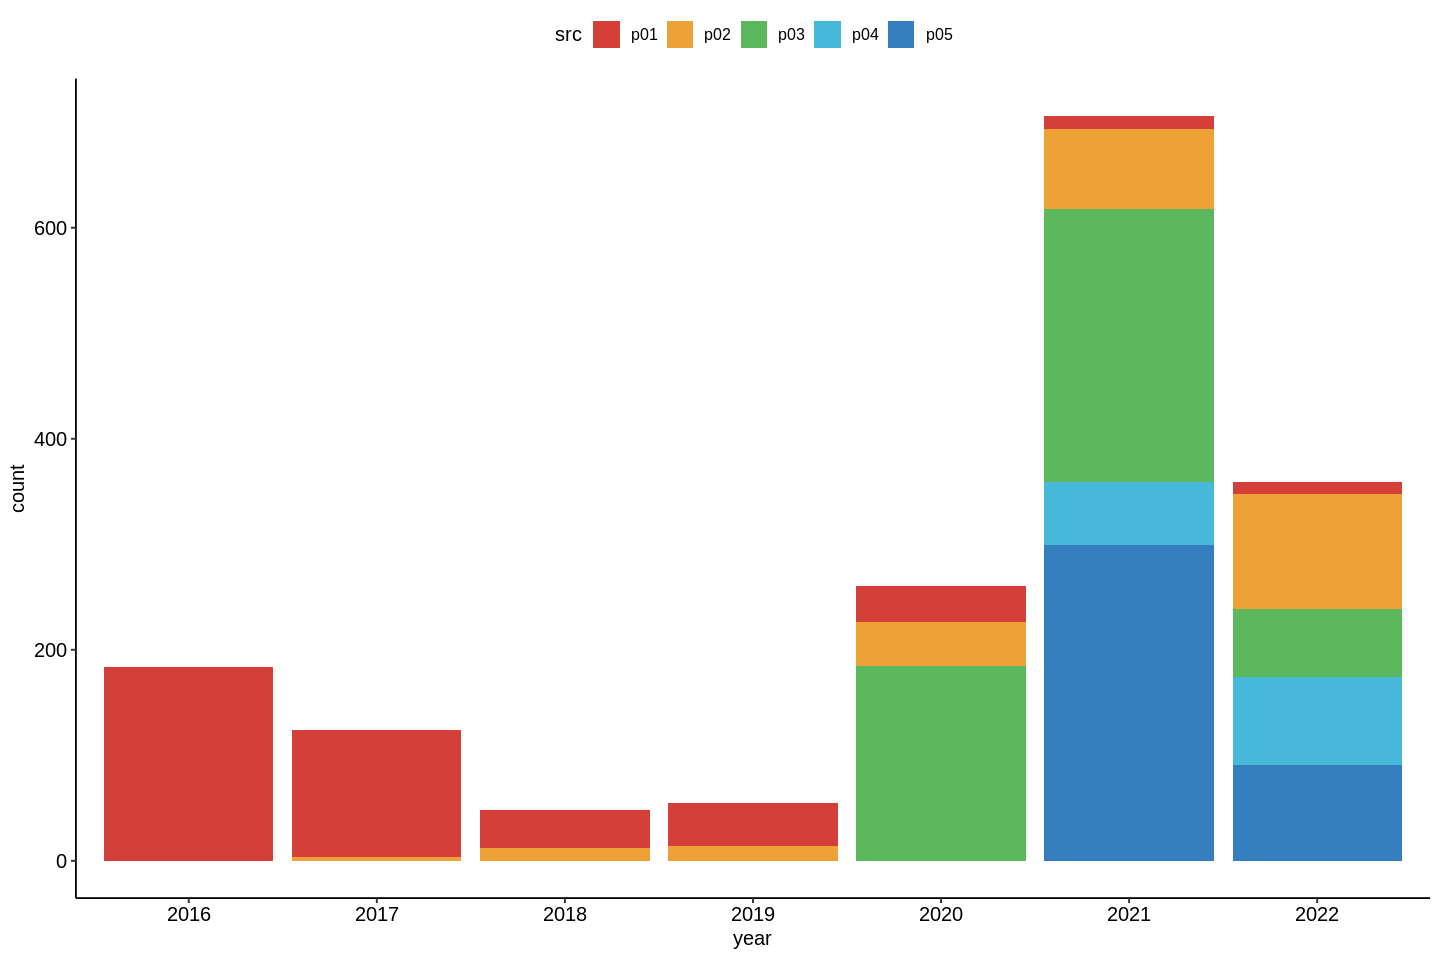

In [ ]:
amazon$data$de %>% 
  ggplot(aes(year, fill = src)) +
  geom_bar() +
  scale_fill_locuszoom() +
  theme_pubr()

### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Ratings by product

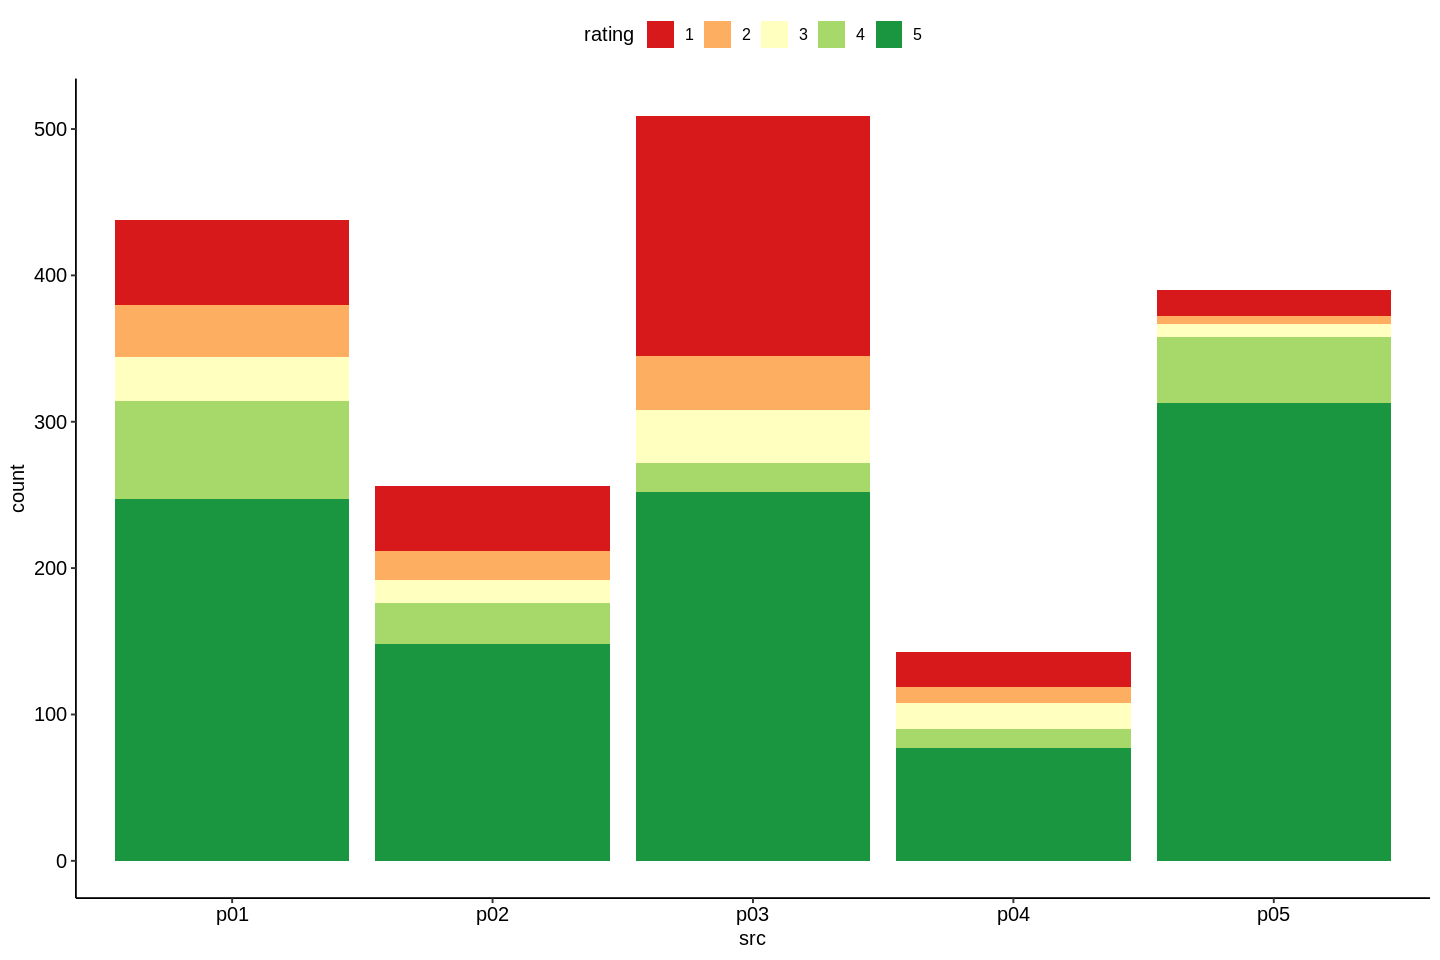

In [ ]:
# Total
amazon$data$de %>% 
  mutate(across(rating, as.factor)) %>% 
  ggplot(aes(src, fill = rating)) + 
  geom_bar() +
  scale_fill_brewer(palette = "RdYlGn") +
  theme_pubr()

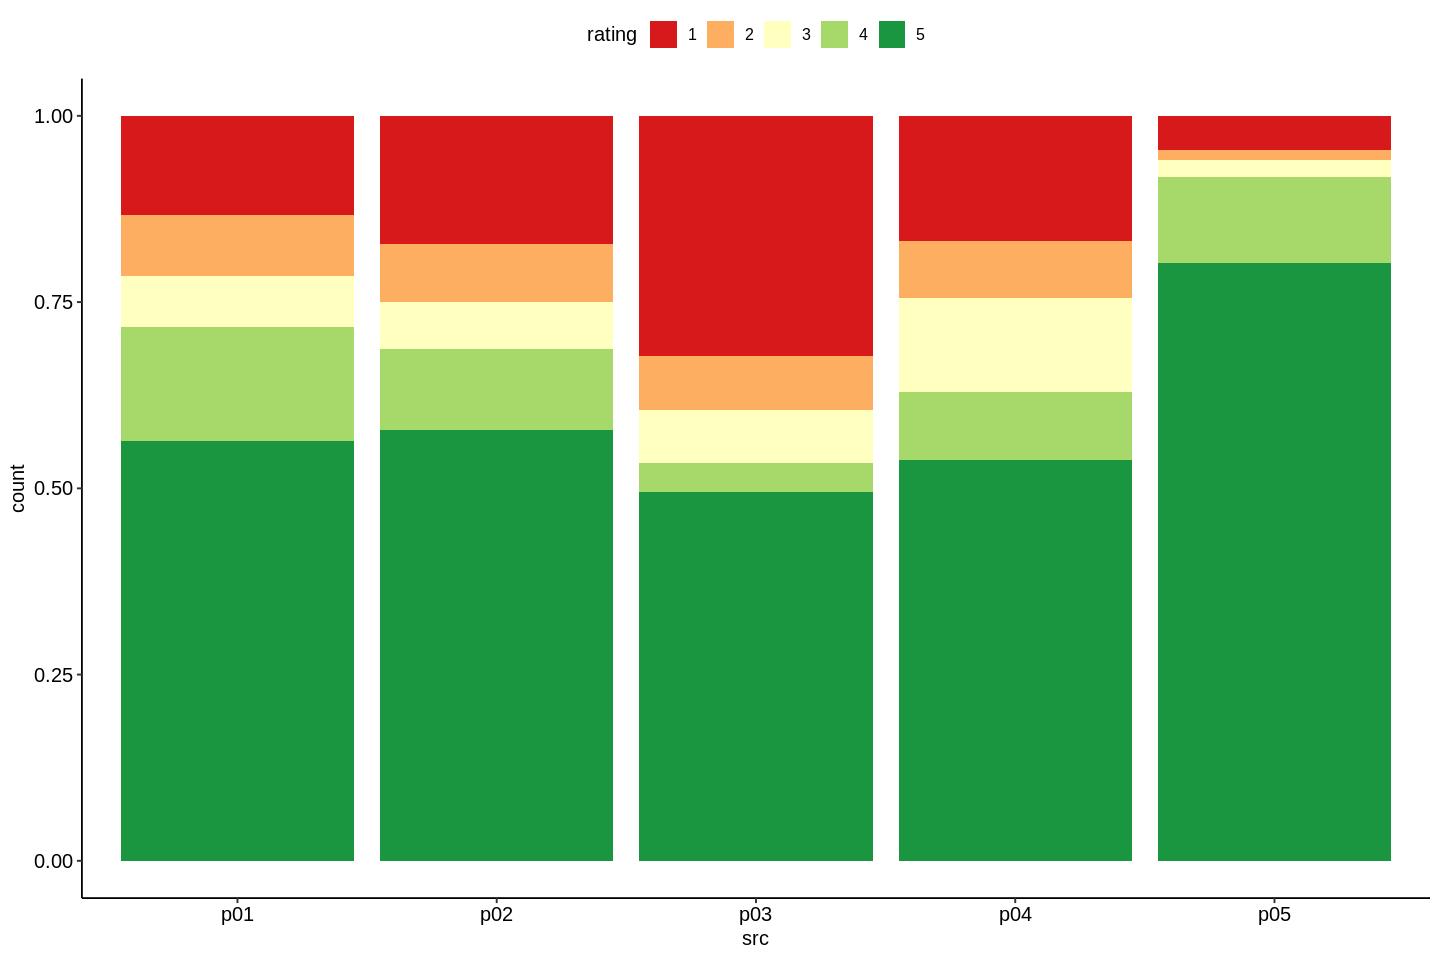

In [ ]:
# Relative 
amazon$data$de %>% 
  mutate(across(rating, as.factor)) %>% 
  ggplot(aes(src, fill = rating)) + 
  geom_bar(position = "fill") +
  scale_fill_brewer(palette = "RdYlGn") +
  theme_pubr()

## Sentiment analysis

### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Load packages

In [ ]:
pacman::p_load(
  quanteda, quanteda.textplots, quanteda.textstats,
  ggdist
)

### Create corpus data


In [ ]:
# Create corpus
amazon$temp$crps <- corpus(
  amazon$data$de,
  docid_field = "id", 
  text_field = "review_body"
)

# Create corpus stats
amazon$temp$crps_stats <- amazon$temp$crps %>% 
  summary(n = 100000) %>% 
  clean_names()

#### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Location parameters

In [ ]:
amazon$temp$crps_stats %>% 
  select(types, tokens, sentences) %>%
  descr()

,var,type,label,n,NA.prc,mean,sd,se,md,trimmed,range,iqr,skew
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
3,types,integer,types,1736,0,41.924539,41.83450,1.00406006,31,34.907914,459 (1-460),37,3.375871
2,tokens,integer,tokens,1736,0,56.161290,74.05660,1.77741523,36,42.781295,1128 (2-1130),48,5.560791
1,sentences,integer,sentences,1736,0,3.563364,3.39087,0.08138349,3,2.927338,37 (1-38),4,3.388298


#### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Length of reviews by source

Joining, by = "src"


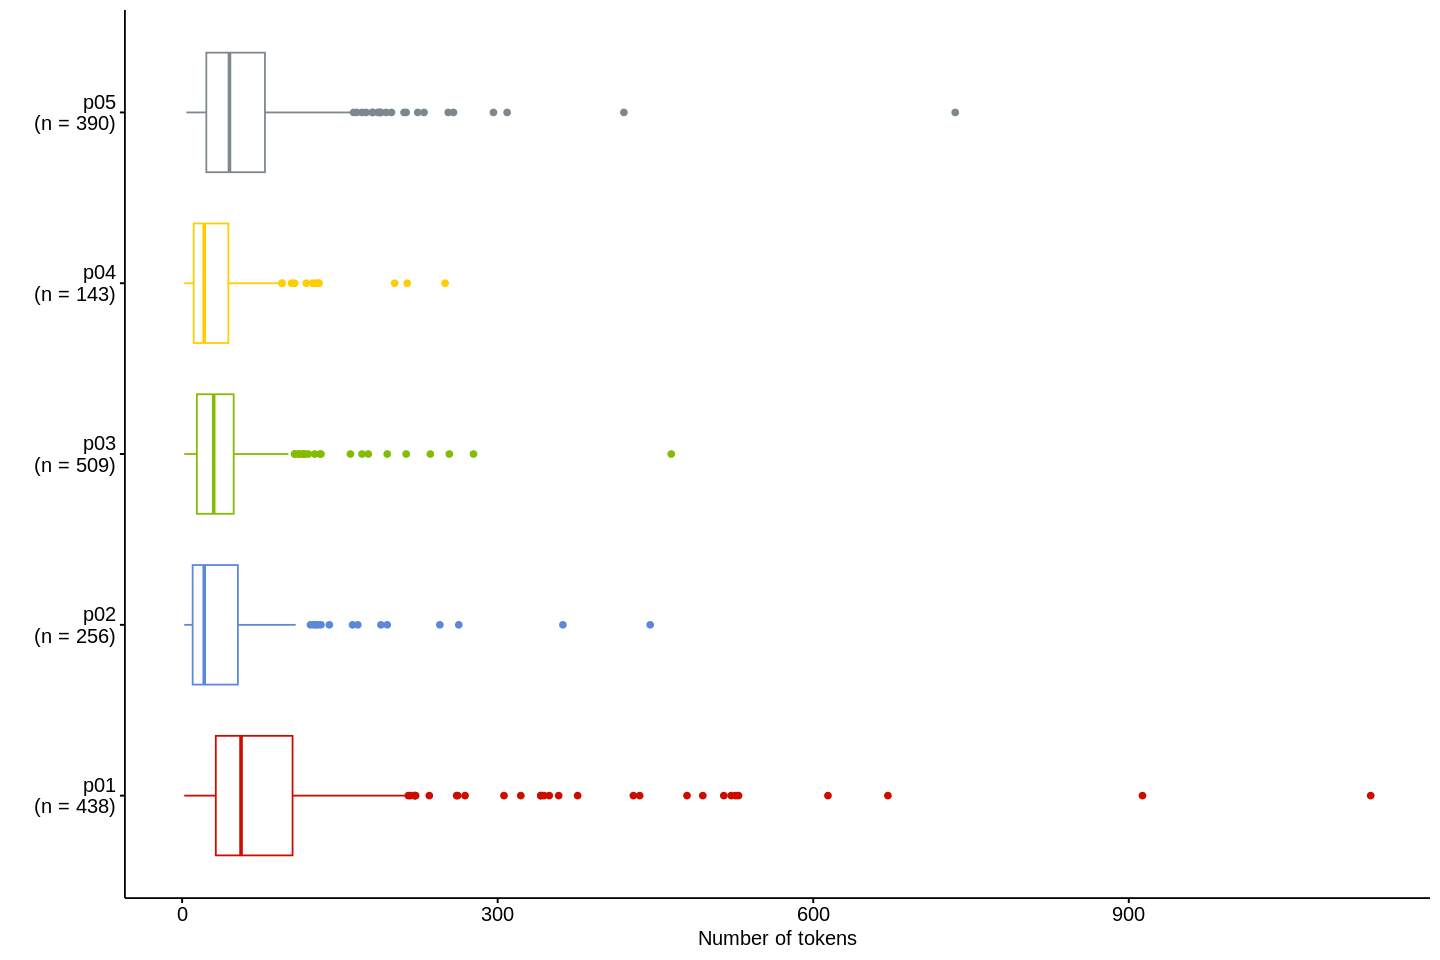

In [ ]:
# add sample size
sample_size <- amazon$temp$crps_stats %>% 
  group_by(src) %>% 
  summarise(n = n())

# Create graph
amazon$temp$crps_stats %>% 
  left_join(sample_size) %>% # Add sample size as label
  mutate(src_label = paste0(src, "\n", "(n = ", n, ")")) %>% 
  ggboxplot("src_label", "tokens", 
            color = "src", palette = "startrek",
            orientation = "horizontal") +
  labs(x = "", y = "Number of tokens") +
  theme(legend.position = "none")

## Join datasets

### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Polarity by product

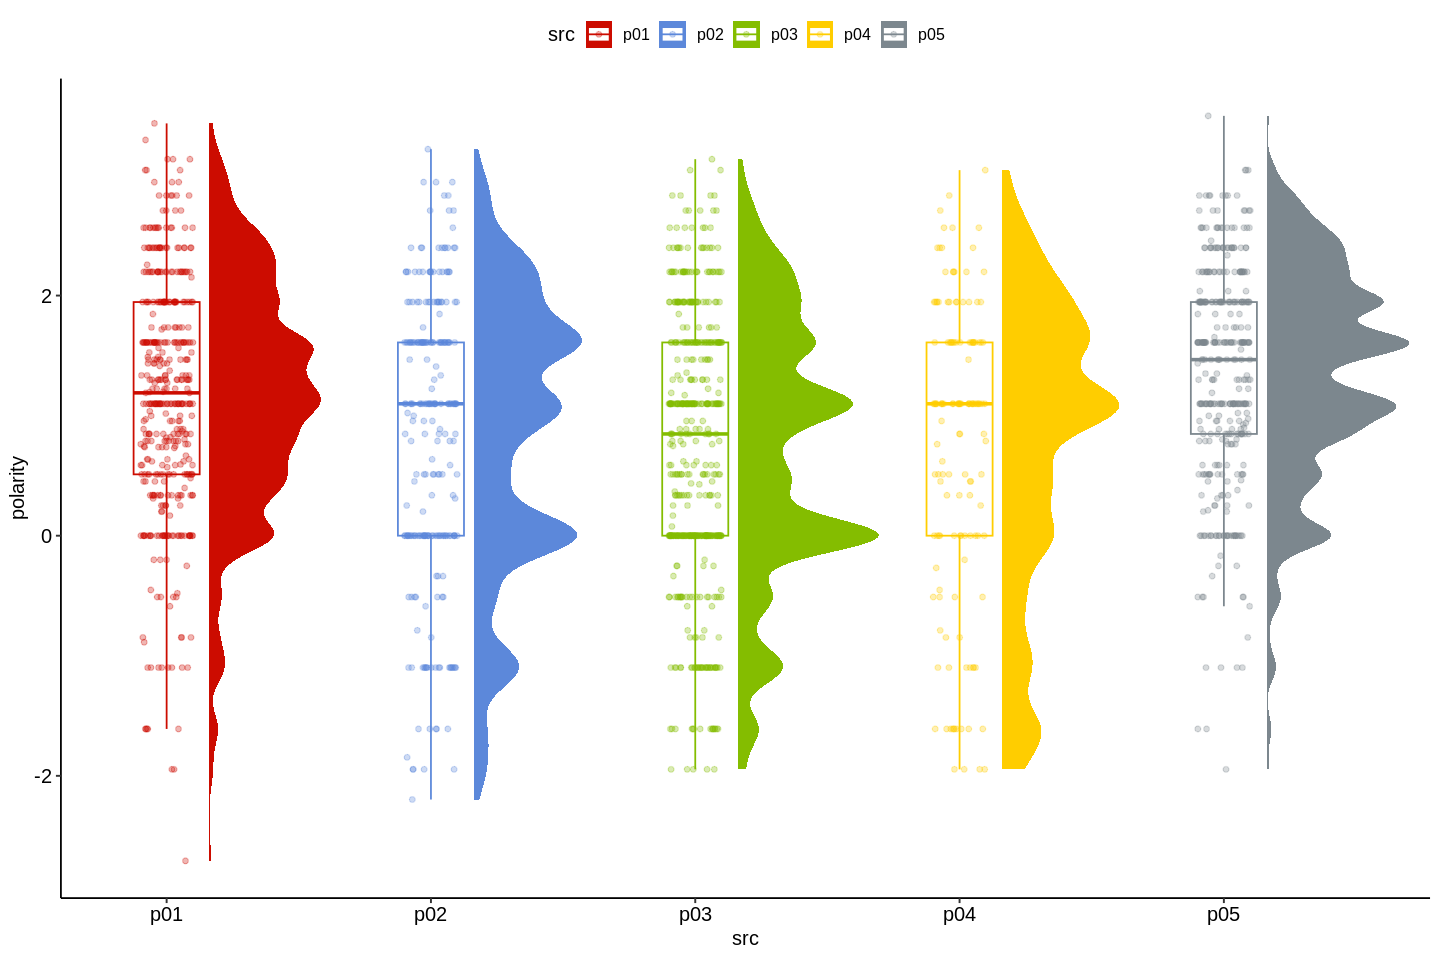

In [ ]:
amazon$data$de_senti %>% 
  ggplot(aes(x = src, y = polarity)) + 
  ggdist::stat_halfeye(
    aes(fill = src),
    adjust = .5, 
    width = .6, 
    .width = 0, 
    justification = -.3, 
    point_colour = NA) + 
  geom_boxplot(
    aes(color = src),
    width = .25, 
    outlier.shape = NA
  ) +
  geom_point(
    aes(color = src),
    size = 1.3,
    alpha = .3,
    position = position_jitter(
      seed = 1, width = .1
    )
  ) + 
  coord_cartesian(xlim = c(1.2, NA), clip = "off") +
  scale_color_startrek() +
  scale_fill_startrek() +
  theme_pubr()

### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Valence by product

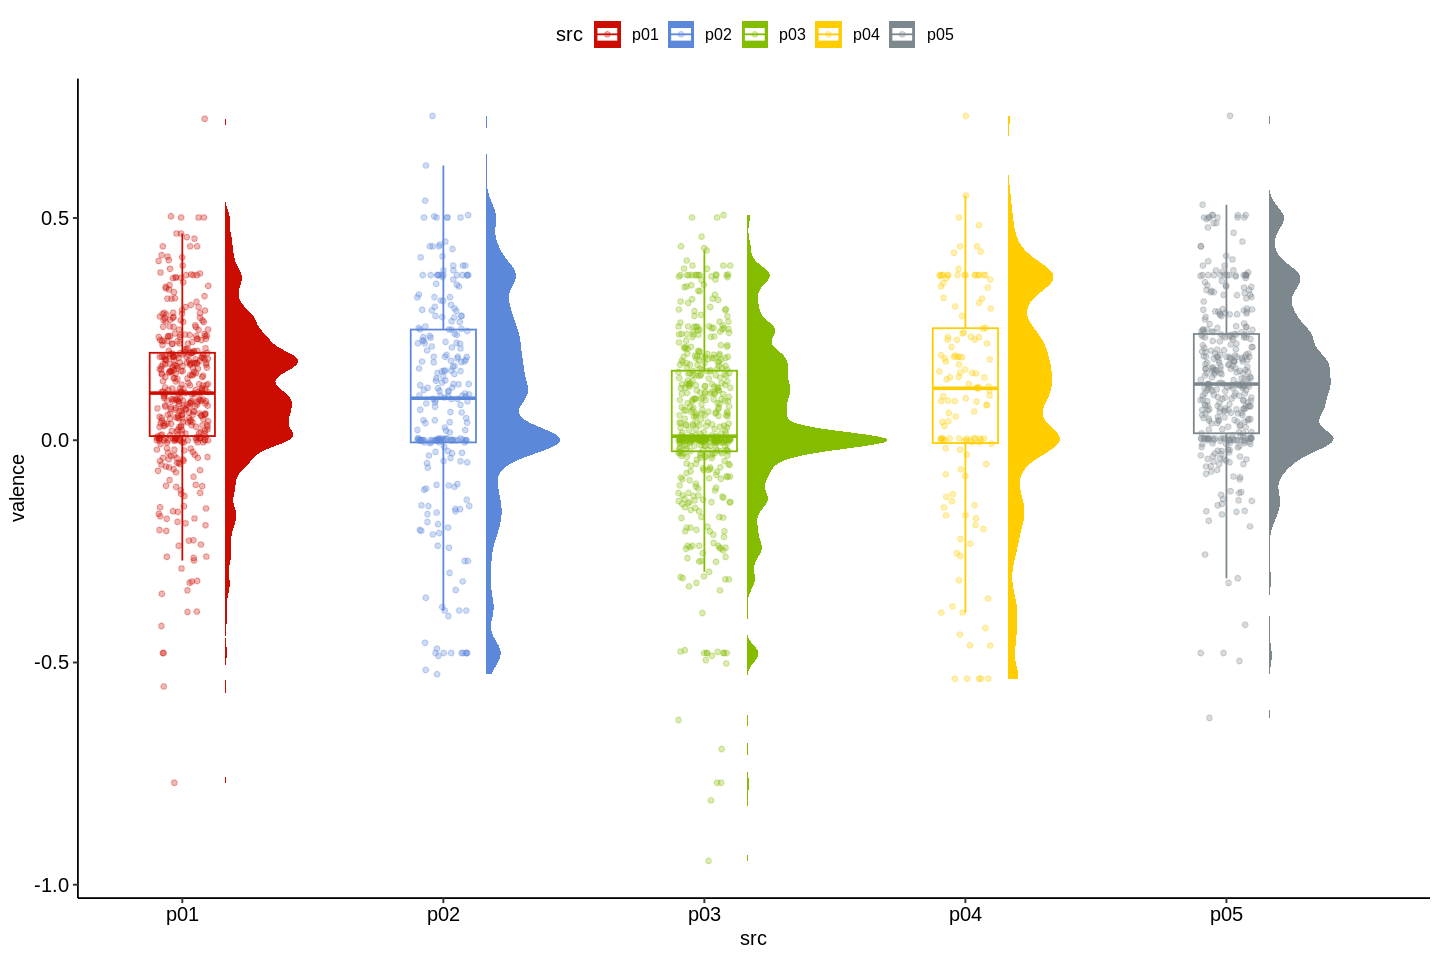

In [ ]:
amazon$data$de_senti %>% 
  ggplot(aes(x = src, y = valence)) + 
  ggdist::stat_halfeye(
    aes(fill = src),
    adjust = .5, 
    width = .6, 
    .width = 0, 
    justification = -.3, 
    point_colour = NA) + 
  geom_boxplot(
    aes(color = src),
    width = .25, 
    outlier.shape = NA
  ) +
  geom_point(
    aes(color = src),
    size = 1.3,
    alpha = .3,
    position = position_jitter(
      seed = 1, width = .1
    )
  ) + 
  coord_cartesian(xlim = c(1.2, NA), clip = "off") +
  scale_color_startrek() +
  scale_fill_startrek() +
  theme_pubr()

### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Ratings by categorical valence

In [ ]:
amazon$data$de_senti %>% 
  flat_table(rating, val_fct)

       val_fct negativ neutral positiv
rating                                
1                  167      40     101
2                   61      11      37
3                   47      14      48
4                   34      10     129
5                  109      16     912

## Topic Modeling

### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Load *packages*

In [ ]:
pacman::p_load(
  quanteda, quanteda.textplots, quanteda.textstats,
  stm, tictoc,
  future
)

### Text processing

In [ ]:
# Corpus creation
amazon$txt$crps <- corpus(
  amazon$data$de_senti,
  docid_field = "doc_id", 
  text_field = "review_body"
)
amazon$txt$crp_stats <- summary(amazon$txt$crps, n = 2500)
# Tokenization
amazon$txt$tkn <- amazon$txt$crps %>% 
  tokens(
    remove_punct = TRUE,
    remove_symbols = TRUE,
    remove_numbers = TRUE,
    remove_url = TRUE,
    remove_separators = TRUE) %>% 
  tokens_remove(pattern = stopwords("de"))
# DFM (Trimming inclusive)
amazon$txt$dfm <- amazon$txt$tkn %>% 
  dfm() %>% 
  dfm_trim(
    min_docfreq = 0.005,
    max_docfreq = 0.99,
    docfreq_type = "prop",
    verbose = TRUE
  )

#### Convert DFM to **STM**

In [ ]:
amazon$tpm$dfm <- convert(amazon$txt$dfm, to = "stm")

#### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Get top features of DFM

In [ ]:
textstat_frequency(
  amazon$txt$dfm, n = 50)

### Choose topic number

#### k = 0

In [ ]:
tic("choose_k_free")

amazon$tpm$nullmdl <- 
  stm(
    documents = dfm_stm$documents,
    vocab = dfm_stm$vocab, 
    prevalence =~ src,
    K = 0, 
    seed = 42,
    max.em.its = 1000,
    data = dfm_stm$meta,
    init.type = "Spectral",
    verbose = FALSE
  )
  
toc(log = TRUE)

In [ ]:
amazon$tpm$nullmdl


A topic model with 44 topics, 1730 documents and a 765 word dictionary.

#### k = c(3:20)

In [ ]:
# Define topic range
topic_range <- c(3:20) # set topic range based on consistency statistics

# Plan
future::plan(future::multisession, workers = 6) # use multiple cores

# Fit models
tic("choose_k_intervall")
amazon$tpm$stm <- tibble(k = topic_range) %>%
  mutate(mdl = furrr::future_map(k, ~stm::stm(
    documents = dfm_stm$documents,
    vocab = dfm_stm$vocab, 
    prevalence =~ src,
    K = ., 
    seed = 42,
    max.em.its = 1000,
    data = dfm_stm$meta,
    init.type = "Spectral",
    verbose = FALSE),
    .options = furrr::furrr_options(seed = 42))
  )
toc(log = TRUE)

### Choose model

#### Create model scores

In [ ]:
# Create heldout data
amazon$tpm$heldout <- make.heldout(
  documents = amazon$tpm$dfm$documents,
  vocab = amazon$tpm$dfm$vocab,
  seed = 42)
  
# create evaluation
amazon$tpm$model_scores <- amazon$tpm$stm %>% 
  mutate(
    exclusivity = map(mdl, exclusivity),
    semantic_coherence = map(mdl,semanticCoherence, amazon$tpm$dfm$documents),
    eval_heldout = map(mdl, eval.heldout, amazon$tpm$heldout$missing),
    residual = map(mdl, checkResiduals, amazon$tpm$dfm$documents),
    bound =  map_dbl(mdl, function(x) max(x$convergence$bound)),
    lfact = map_dbl(mdl, function(x) lfactorial(x$settings$dim$K)),
    lbound = bound + lfact,
    iterations = map_dbl(mdl, function(x) length(x$convergence$bound)))

#### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15">  Compare model scores

In [ ]:
# Tibble
amazon$tpm$model_scores %>% 
  transmute(
    k,
    `Lower bound` = lbound,
    Residuals = map_dbl(residual, "dispersion"),
    `Semantic coherence` = map_dbl(semantic_coherence, mean),
    `Held-out likelihood` = map_dbl(eval_heldout, "expected.heldout")) %>% 
  tibble()

In [ ]:
# Graphics
amazon$tpm$model_scores %>% 
  transmute(
    k,
    `Lower bound` = lbound,
    Residuals = map_dbl(residual, "dispersion"),
    `Semantic coherence` = map_dbl(semantic_coherence, mean),
    `Held-out likelihood` = map_dbl(eval_heldout, "expected.heldout")) %>%   
  pivot_longer(-k, names_to = "Metric", values_to = "Value") %>% 
  ggplot(
    aes(k, Value, color = Metric)) +
  geom_line(size = 1.5, alpha = 0.7, show.legend = FALSE) +
  facet_wrap(~Metric, scales = "free_y") +
  labs(x = "K (number of topics)",
       y = NULL,
       title = "Model diagnostics by number of topics")

#### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Exclusivity by coherence


In [ ]:
amazon$tpm$model_scores %>%
  select(k, exclusivity, semantic_coherence) %>%
  filter(k %in% c(5, 7, 11)) %>%
  unnest(cols = c(exclusivity, semantic_coherence)) %>%
  mutate(k = as.factor(k)) %>%
  ggplot(aes(semantic_coherence, exclusivity, color = k)) +
  geom_point(size = 2, alpha = 0.7) +
  labs(x = "Semantic coherence",
       y = "Exclusivity",
       title = "Comparing exclusivity and semantic coherence",
       subtitle = "Models with fewer topics have higher semantic coherence for more topics, but lower exclusivity") 

## Model understanding

### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Install & load packages

In [ ]:
pacman::p_load(
  rmarkdown, kableExtra
)

### Select model

In [ ]:
amazon$stm$mdl <- amazon$tpm$stm %>% 
  filter(k == 5) %>% 
  pull(mdl) %>% 
  .[[1]]

### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Model interpretation

In [ ]:
# Model statistics
amazon$stm$mdl

A topic model with 5 topics, 1730 documents and a 765 word dictionary.

In [ ]:
# Model interpretation
amazon$stm$mdl %>% labelTopics()

#### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Features (Highest Prob)

In [ ]:
labelTopics(amazon$stm$mdl, n = 15)$prob %>%
  t() %>% 
  as.data.frame() %>% 
  janitor::clean_names() %>% 
  tibble() %>% 
  rename_with(.fn = ~ stringr::str_replace(., "v", "topic_"), .cols = v1:v5)

In [ ]:
labelTopics(amazon$stm$mdl, n = 15)$prob%>%
  as.data.frame() %>% 
  janitor::clean_names() %>% 
  tibble() %>% 
  rownames_to_column(var = "topic") %>% 
  mutate(prob = paste(v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,
                      v11, v12, v13, v14, v15, 
                      sep = "; ")) %>% 
  select(topic, prob) 

#### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Features (FREX)

In [ ]:
labelTopics(amazon$stm$mdl, n =15)$frex %>%
  t() %>% 
  as.data.frame() %>% 
  janitor::clean_names() %>% 
  tibble() %>% 
  rename_with(.fn = ~ stringr::str_replace(., "v", "topic_"), .cols = v1:v5) 

In [ ]:
labelTopics(amazon$stm$mdl, n =15)$prob %>%
  as.data.frame() %>% 
  janitor::clean_names() %>% 
  tibble() %>% 
  rownames_to_column(var = "topic") %>% 
  mutate(prob = paste(v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,
                      v11, v12, v13, v14, v15, 
                      sep = "; ")) %>% 
  select(topic, prob) 

#### Prevalence

##### Create data

In [ ]:
amazon$stm$preval <- list(
  terms_beta = amazon$stm$mdl %>% tidy(),
  doc_gamma = amazon$stm$mdl %>% tidy("gamma")
)
amazon$stm$preval$top_terms <- amazon$stm$preval$terms_beta %>% 
  arrange(., beta) %>%
  group_by(topic) %>%
  top_n(10, beta) %>%
  arrange(-beta) %>%
  select(topic, term) %>%
  summarise(terms = list(term)) %>%
  mutate(terms = map(terms, paste, collapse = ", ")) %>%
  unnest(cols = c(terms))
  
amazon$stm$preval$top_topics <- amazon$stm$preval$doc_gamma %>%
  group_by(., topic) %>%
  summarise(gamma = mean(gamma)) %>%
  arrange(desc(gamma))
amazon$stm$preval$tgt <- amazon$stm$preval$top_topics %>% 
  left_join(amazon$stm$preval$top_terms, by = "topic") %>%
  mutate(topic = paste0("Topic ", topic),
         topic = reorder(topic, gamma))

##### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Visual analysis

In [ ]:
options(repr.plot.width=12, repr.plot.height=8)

amazon$stm$preval$tgt  %>% 
  ggplot(aes(topic, gamma, label = terms, fill = topic)) +
  geom_col(show.legend = FALSE) +
  geom_text(hjust = 1.1, nudge_y = 0.0005, size = 3, color = "white") +
  coord_flip() +
  scale_y_continuous(expand = c(0, 0), limits = c(0, 0.35), labels = scales::percent) +
  theme_bw() +
  theme(panel.grid.minor = element_blank(),
        panel.grid.major = element_blank()) +
  labs(x = NULL, y = expression(gamma)) +
  scale_fill_jama()

## Topic analysis

### Preparation


### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Install & load packages

In [ ]:
pacman::p_load(
  sjlabelled,
  glue
)

#### Get gamma statistics for the documents


In [ ]:
amazon$stm$merge <- list(
  doc_gamma_wide = amazon$stm$preval$doc_gamma %>% 
    group_by(document) %>% 
    pivot_wider(
      id_cols = document,
      names_from = "topic", 
      names_prefix = "gamma_topic_",
      values_from = "gamma") %>% 
    rename(doc_id_gamma = document),
  doc_gamma_top = amazon$stm$preval$doc_gamma %>%
    group_by(document) %>% 
    slice_max(gamma) %>% 
    rename(
      top_topic = topic,
      top_gamma = gamma)
  )

#### Join with original data set


In [ ]:
amazon$data$tpm <- amazon$data$de_senti %>% 
  filter(
    doc_id != 108 & doc_id != 790 &
    doc_id != 914 & doc_id!= 1328 &
    doc_id != 1349 & doc_id != 1706) %>% 
  bind_cols(amazon$stm$merge$doc_gamma_top) %>% 
  fastDummies::dummy_cols(., select_columns = c("top_topic")) %>% 
  bind_cols(amazon$stm$merge$doc_gamma_wide) %>% 
  select(!doc_id_gamma) %>% 
  mutate(across(top_topic, as.factor))

### Explorative analysis

#### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Topic over years

In [ ]:
amazon$data$tpm %>% 
  ggplot(aes(year, fill = top_topic)) +
  geom_bar() +
  scale_fill_locuszoom() +
  theme_pubr()

#### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Topic by proudct

In [ ]:
amazon$data$tpm %>% 
  flat_table(top_topic, src)

### Top reviews of each topic

#### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Preparation

In [ ]:

top_stories <- list()
select_topic <- paste0("_", seq(from = 1, to = 5, by = 1))
for (i in select_topic) {
  i_gamma <- paste0("gamma_topic", i)
  i_topic <- paste0("top_topic", i)
  
  top_stories[[i_gamma]] <- 
    amazon$data$tpm[order(amazon$data$tpm[i_gamma], decreasing = TRUE),] |>
    select(id, date, src, review_title, review_text, review_star,
           valence, polarity, pol_fct, val_fct,
           top_gamma, all_of(i_gamma),
           top_topic, all_of(i_topic), review_body) |>
    rename(
      gamma = all_of(i_gamma),
      top_topic_d = all_of(i_topic)
      ) |>
    dicho(gamma, dich.by = 0.49, suffix = "_d") |>
    mutate(
      across(top_topic_d, as.factor),
      gamma_top  = case_when(top_topic_d == 1 ~ gamma, TRUE ~ NA_real_),
      gamma_main = case_when(gamma_d == 1 ~ gamma, TRUE ~ NA_real_),
    ) |>
    relocate(review_body, .after = top_topic) 
  }

Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”


##### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Create output

In [ ]:
output <- list()

gamma_topics <- amazon$data$tpm %>% 
  select(starts_with("gamma_topic_")) %>% 
  colnames()
  
for (i in gamma_topics) {
  # Create dataset
  output[[i]]$data <- top_stories[[i]] |>
    filter(top_topic_d == 1)
  
  # Create crosstable
  output[[i]]$crosstable <- top_stories[[i]] |>
    select(top_topic_d, gamma_d) %>% 
    mutate(
      across(everything(), add_labels, labels = c("No" = 0, "Yes" = 1)),
      across(top_topic_d, set_label, label = "Highest realtive gamma"),
      across(gamma_d, set_label, label = "Highest absolute gamma")
    ) |>
    label_to_colnames() |>
    flat_table()
  
  # Create descriptive statistics: location parameters for different gammas
  output[[i]]$desc_gamma <- top_stories[[i]] |>
     select(gamma_top, gamma_main) |>
     mutate(
       across(gamma_top, set_label, label = "Highest realtive gamma"),
       across(gamma_main, set_label, label = "Highest absolute gamma")
       ) |>
       descr(show = c("label", "n", "NA.prc", "mean", "sd", "se", "md", "range"))
 }

#### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Create custom function `print_output_descriptives`

In [ ]:
print_output_descriptives <- function(x) {
  # Loop
  for (i in x) {
    # Headline
    cat(paste("Results for", i, "\n"))
    # Mutli-topic abstracts
    glue("## Check for ambiguous topic assignment for review:
Comments: 
- Highest relative gamma: Is {i} the top topic of the review?
- Highest absolute gamma: Is the gamme value for {i} higher than 0.5
 \n") |> print()
    # Crosstable 
   output[[i]]$crosstable |> print()
    # Location parameters
   output[[i]]$desc_gamma |> print()
  }
}
print_output_abstracts <- function(x) {
  # Loop
  for (i in x) {
    for (j in c(1:5)) {
      glue("
           ***************************************************
           
           ID: {output[[i]]$data$id[[j]]} \n
           Date: {output[[i]]$data$date[[j]]} \n
           Title: {output[[i]]$data$review_title[[j]]} \n
           Gamma: {round(output[[i]]$data$gamma[[j]],3)} \n
           Review: \r
           {output[[i]]$data$review_text[[j]]} \n
           Rating: {output[[i]]$data$review_star[[j]]} \n
           Valence: {output[[i]]$data$val_fct[[j]]} ({round(output[[i]]$data$valence[[j]],3)}) \n
           Polarity: {output[[i]]$data$pol_fct[[j]]} ({round(output[[i]]$data$polarity[[j]],3)}) 
           \n\n") |> print() 
    }
  }
}

#### Output by topics

##### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Topic 1 (Descriptives & Abstracts)


In [ ]:
print_output_descriptives(gamma_topics[1])

In [ ]:
print_output_abstracts(gamma_topics[1])

##### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Topic 2 (Descriptives & Abstracts)


In [ ]:
print_output_descriptives(gamma_topics[2])

In [ ]:
print_output_abstracts(gamma_topics[2])

##### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Topic 3 (Descriptives & Abstracts)


In [ ]:
print_output_descriptives(gamma_topics[3])

In [ ]:
print_output_abstracts(gamma_topics[3])

##### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Topic 4 (Descriptives & Abstracts)


In [ ]:
print_output_descriptives(gamma_topics[4])

In [ ]:
print_output_abstracts(gamma_topics[4])

##### <img src="https://icons.getbootstrap.com/assets/icons/file-play-fill.svg" width="15" height="15"> Topic 5 (Descriptives & Abstracts)


In [ ]:
print_output_descriptives(gamma_topics[5])

In [ ]:
print_output_abstracts(gamma_topics[5])